# Pre trained network
![imagen](https://www.researchgate.net/publication/336874848/figure/fig1/AS:819325225144320@1572353764073/Illustrations-of-transfer-learning-a-neural-network-is-pretrained-on-ImageNet-and.png)

Estas son las arquitecturas de redes neuronales más utilizadas en la comunidad. Para más detalle sobre el funcionamiento de cada red, consultar el [Hands on Machine Learning for Python](https://learning.oreilly.com/library/view/hands-on-machine-learning/9781492032632/ch14.html#cnn_chapter).
* VGG-16
* VGG-19
* Inception V3
* XCeption
* ResNet-50

Las redes se pueden incorporar entrenadas, o sin entrenar.

## Inception

In [39]:
import tensorflow as tf
# from tensorflow.keras.preprocessing import image
from tensorflow.keras import layers, models # datasets, 
# import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread
import cv2

# from tensorflow.keras.applications.resnet_v2 import ResNet50V2, decode_predictions, preprocess_input

# IM_SIZE = 64

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split

# IM_SIZE=64

TRAIN_PATH = 'C:/Users/alber/OneDrive/Escritorio/dogs&cats/train'
TEST_PATH = 'C:/Users/alber/OneDrive/Escritorio/dogs&cats/test'

filenames = os.listdir(TRAIN_PATH)
categories = []

for filename in filenames:
    category = filename.split('.')[0]
    categories.append(category)
    # if category == 'dog':
    #     categories.append(1)
    # else:
    #     categories.append(0)
        
df = pd.DataFrame({
    'filenames': filenames,
    'category': categories
})

train_df, validate_df = train_test_split(df,
                                         test_size=0.20,
                                         random_state=42,
                                         stratify=categories)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [49]:
train_df.category.value_counts(normalize=True)

dog    0.5
cat    0.5
Name: category, dtype: float64

In [50]:
validate_df.category.value_counts(normalize=True)

dog    0.5
cat    0.5
Name: category, dtype: float64

### Inception

In [51]:
from keras.preprocessing.image import ImageDataGenerator


# Add our data-augmentation parameters to ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40, # Rotacion en grados
                                   width_shift_range = 0.2, # Desplazamiento a lo ancho
                                   height_shift_range = 0.2,
                                   shear_range = 0.2, # Intensidad del angulo de rotacion
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Note that the validation data should not be augmented!
validation_datagen = ImageDataGenerator(rescale = 1.0/255. )

In [52]:
IM_SIZE=224

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    TRAIN_PATH,
                                                    x_col='filenames',
                                                    y_col='category',
                                                    batch_size = 20,
                                                    class_mode = 'binary',
                                                    target_size = (IM_SIZE, IM_SIZE))

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_dataframe(validate_df,
                                                              TRAIN_PATH,
                                                              x_col='filenames',
                                                              y_col='category',
                                                              batch_size = 20,
                                                              class_mode = 'binary',
                                                              target_size = (IM_SIZE, IM_SIZE))

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


0.0


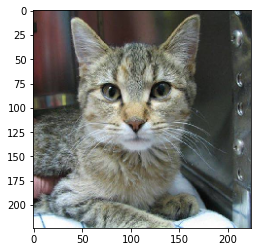

0.0


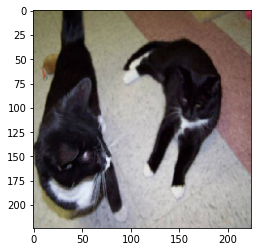

0.0


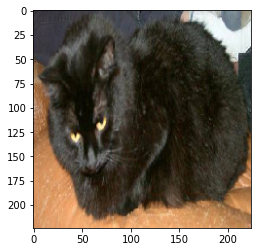

In [55]:
x,y = validation_generator.next()
for i in range(0,3):
    image = x[i]
    label = y[i]
    print (label)
    plt.imshow(image)
    plt.show()

In [15]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

base_model = InceptionV3(input_shape = (IM_SIZE, IM_SIZE, 3),
                         include_top = False,
                         weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False

In [16]:
from tensorflow.keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

# earlystop = EarlyStopping(patience=10, monitor='val_loss')

inc_history = model.fit(train_generator,
                      validation_data = validation_generator,
                      steps_per_epoch = 100,
                      epochs = 1,
                      callbacks=[earlystop])


100/100 [==============================] - 601s 6s/step - loss: 1.2307 - acc: 0.8995 - val_loss: 0.1575 - val_acc: 0.9768


In [33]:
from datetime import datetime
datestr = datetime.now().strftime('%d_%m-%H_%M')
file = 'catsdogs'
pretr = 'inception'
ext = '.h5'

filename = '_'.join([file, pretr, datestr]) + ext
path = os.path.join('model', filename)
path

'model\\catsdogs_inception_28_06-12_13.h5'

In [34]:
model.save(path)